In [1]:
%load_ext autoreload
%autoreload 2

from model_utils import train_model, split_data, split_branches, get_model, set_pretrained_model_dropout
from config import Config
import json
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import os
import datasets
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from model_manager import ModelManager

In [2]:
# seed = random.randint(0, 2 ** 32 - 1)
seed = 3218885689
random.seed(seed)
datasets.logging.set_verbosity(datasets.logging.ERROR)
# Tell pytorch to run this model on the GPU.
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
# device_name = "cpu"
device = torch.device(device_name)
print(f"Will use {device_name} for training with seed: {seed}")

Will use cuda:0 for training with seed: 3218885689


In [3]:
split_data(os.path.join(Config.work_dir, "awsw_story_input.txt"))

In [4]:
config = {
    "lr": 6e-4,
    "warmup_factor": 0,
    "scheduler": "polynomial_decay_schedule_with_warmup",
    "lr_end": 2e-6,
    "power": 0.6,
    #"freeze_layer_rate": 1e-4,
    "freeze_from_steps": -1,
    "seed": seed,
    "num_epoch": 100
}

optuna_result_attachement = {
    'lr': 0.001,
    'scheduler': 'cosine_schedule_with_warmup',
    'to_freeze_count': 157,
    #"to_freeze_gpt_blocks": 11,
    'warmup_factor': 1
}
config.update(optuna_result_attachement)

In [5]:
saved_model_path = os.path.join("models", "awsw_main")
if os.path.exists(os.path.join(saved_model_path, "pytorch_model.bin")):
    print("Pretrained model loaded")
    tokenizer = AutoTokenizer.from_pretrained('EleutherAI/gpt-neo-125M')
    model = AutoModelForCausalLM.from_pretrained(saved_model_path)
else:
    print("Loaded empty model")
    model, tokenizer = get_model("EleutherAI/gpt-neo-125M")
model.to(device)
# set_pretrained_model_dropout(model.transformer.h[-1:], 0.05)

Loaded empty model


GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0, inplace=False)
    (h): ModuleList(
      (0): GPTNeoBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0, inplace=False)
            (resid_dropout): Dropout(p=0, inplace=False)
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=False)
            (q_proj): Linear(in_features=768, out_features=768, bias=False)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear(in_features=3072, o

# Test before training on a pretrained model!

In [6]:
model.eval()
model_manager = ModelManager(model=model, tokenizer=tokenizer)
def test_regular_sampler():
    print(model_manager.say_raw("How are you? I'm", 50, 0.7))
test_regular_sampler()

How are you? I'm going to be honest, I'm a little tired of this, I'm tired of this, and I'm going to be honest with you, I'm going to be honest with you, and I'm going to be honest with you, and I'm going to be honest with you, and I'm going to be honest with you, and I'm going to be honest with you, and I'm going to be honest with you, and I'm going to be honest with you, and I'm going to be honest with you, and I'm going to be honest with you, and I'm going


# Training

Model is put in training mode and we begin training. The `train_results` will contain all data after training is completed.

In [7]:
train_results = {}
model.train()
train_model(model, tokenizer, config, train_results)

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset text downloaded and prepared to /home/awsw-dev/.cache/huggingface/datasets/text/default-bb7269ada5f39e1e/0.0.0/e16f44aa1b321ece1f87b07977cc5d70be93d69b20486d6dacd62e12cf25c9a5. Subsequent calls will reuse this data.


Token indices sequence length is longer than the specified maximum sequence length for this model (3376 > 2048). Running this sequence through the model will result in indexing errors


Dataset demo snapshot:
<d><scn>loremapt<msg>Ip "I work in the facility as a biologist with a minor in physics."<|endoftext|><d><scn>np1n<msg>Mv "She killed them, and you protect her?"<|endoftext|><d><scn>emeraroom<msg>Em "Let me ask you one thing, [player_name]: Do you enjoy your work as ambassador?"<|endoftext|><d><scn>cafe<msg>An "You bet I will. In any case, I should get going now. My "<|endoftext|><d><scn>be
ach<msg>m "Once more, Adine took to the sky to hunt for fish. While it was interesting to watch her for a bit, she kept hunting for a while, and I started passing the time by collecting some seashells."<|endoftext|><p><msg>c "Err..."<|endoftext|><d><scn>black<msg>Ry "I don't know. I suppose you have a point."<|endoftext|><p><msg>c "No problem."<|endoftext|><p><msg>c "See you soon, then?"<d><scn>cafe<msg>An "Of course.
[0] set freeze_part_layers: True (freezing 157 out of 160 layers.)


Step,Training Loss
105,3.844100
210,3.597700
315,3.318900
420,3.135300
525,3.006200
630,2.908300
735,2.836200
840,2.773000
945,2.725200
1050,2.687200


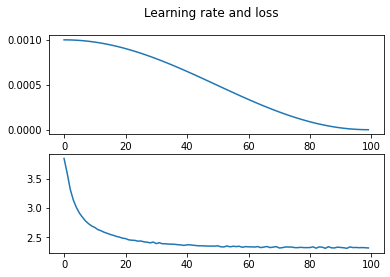

In [8]:
fig, axs = plt.subplots(2)
fig.suptitle('Learning rate and loss')
axs[0].plot(train_results['learning_rate_history'])
axs[1].plot(train_results['loss_history'])

# Testing

We created a few past (for context) + present prompts (player input) and see the different reactions. This way, we can test the models across different iterations.
The first test involves a old prompt to compare the pre-trained model with the one trained on AWSW. Did it manage to store it's data well? Is it able to write down things that have nothing to do with AWSW? (So we know we didn't overfit).

In [9]:
model.eval()
test_regular_sampler()

How are you? I'm wondering if you're going to stay in this hotel, or if you want to come and go around for a few days."<|endoftext|>


**This test generates boring and repetetive** replies! It's because we use no good sampling algorithm, but it does give us a indication of what the model has learned!

In [10]:
prompts = [
    ('<p><msg>c "Hey Remy!"<d><scn>park2<msg>Ry "Hey!"', "How are you?"),
    ('<p><msg>c "I was with Lorem today."<d><scn>park2<msg>Ad "Very nice."', "What do you think of Lorem?"),
    ('<p><msg>m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('<p><msg>m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
]

for (past, prompt) in prompts:
    reply = model_manager.say(past, prompt)
    print(f"Prompt: {prompt}\nReply: {reply}\n\n")

Prompt: How are you?
Reply: park2<msg>Ry "Hey!"<p><msg>c "Hey!"<d><scn>park2<msg>Ry "Hey!"<p><msg>c "Hey!"<d><scn>park2<msg>Ry "Hey!"<p><msg>c "Hey!"<d><scn>park2<msg>Ry "Hey!"<p><msg>


Prompt: What do you think of Lorem?
Reply: park2<msg>Ad "I think it's a good idea."<d><scn>park2<msg>Ad "I think it's a good idea."<d><scn>park2<msg>Ad "I think it's a good idea."<d><scn>park2<msg>Ad "I think it's a good idea


Prompt: Oh my god, Adine. What is this?
Reply: c "I'm not sure. I'm not sure what I should do."<d><scn>c "I'm not sure what I should do."<d><scn>c "I'm not sure what I should do."<d><scn>c "I'm not sure what I should do."<d><scn>c "I'm not sure what I should do."<


Prompt: What will we do here?
Reply: c "I'm not sure. I'm not sure what I should do."<d><scn>c "I'm not sure what I should do."<d><scn>c "I'm not sure what I should do."<d><scn>c "I'm not sure what I should do."<d><scn>c "I'm not sure what I should do."<d><scn>c




# Sampling test

This is gonna be interesting!

In [ ]:
for i in range(10):
    for (past, prompt) in prompts:
        reply = model_manager.say(past, prompt, top_k = 50, top_p = 0.7)
        print(f"[Test {i + 1}] -> Prompt: {prompt}\nReply: {reply}\n")
    print("-------------")

[Test 1] -> Prompt: How are you?
Reply: park2<msg>Ry "Oh, really?"<d><scn>park2<msg>c "No, you're in a hurry. Come in here, right?"<d><scn>park2<msg>c "So you're here?"<d><scn>park2<msg>c "Yeah, I've been around before. I'm just gonna walk around and look at

[Test 1] -> Prompt: What do you think of Lorem?
Reply: park2<msg>Ad "Very nice."<scn>park2<msg>Ad "Very nice."<scn>park2<msg>Ad "Very nice."<scn>park2<msg>Ad "Very nice."<scn>park2<msg>Ad "Very nice."<scn>park2<msg>Ad "

[Test 1] -> Prompt: Oh my god, Adine. What is this?
Reply: black<msg>n "Oh, my god, Adine. What is that?"<d><scn>black<msg>c "Oh, I see."<p><msg>c "Oh, that's it."<d><scn>black<msg>c "Oh, I see."<d><scn>black<msg>c "That's why I'm here."<

[Test 1] -> Prompt: What will we do here?
Reply: c "You'll find out later."<|endoftext|>

-------------
[Test 2] -> Prompt: How are you?
Reply: park2<msg>Ry "You look great."<d><scn>park2<msg>Ry "That's what I wanted to see."<d><scn>park2<msg>Ry "You seem to be quite active."<d>

In [12]:
print("What to say?")
print(generate_dragon_reply("", input()))

What to say?


NameError: name 'generate_dragon_reply' is not defined